In [5]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from bokeh.plotting import figure, output_file, show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker, LogTicker, ContinuousTicker, AdaptiveTicker,
    PrintfTickFormatter,
    ColorBar,
    FactorRange
)
import bokeh.palettes
from bokeh.transform import factor_cmap
from wordcloud import WordCloud, STOPWORDS
from math import floor
from bokeh.io import output_notebook
from bokeh.models import NumeralTickFormatter

In [6]:
output_notebook()

Loading BokehJS ...

In [7]:
data = pd.read_csv("../data/cleaned_data.csv")

In [8]:
data["profit"] = data["revenue"] - data["budget"]

In [9]:
data.head(3).transpose()

,0,1,2
budget,237000000,300000000,245000000
genres,"['Action', 'Adventure', 'Fantasy', 'Science Fi...","['Adventure', 'Fantasy', 'Action']","['Action', 'Adventure', 'Crime']"
keywords,"['culture clash', 'future', 'space war', 'spac...","['ocean', 'drug abuse', 'exotic island', 'east...","['spy', 'based on novel', 'secret agent', 'seq..."
original_language,en,en,en
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...
popularity,150.438,139.083,107.377
production_companies,"['Ingenious Film Partners', 'Twentieth Century...","['Walt Disney Pictures', 'Jerry Bruckheimer Fi...","['Columbia Pictures', 'Danjaq', 'B24']"
production_countries,"['United States of America', 'United Kingdom']",['United States of America'],"['United Kingdom', 'United States of America']"
release_date,2009-12-10,2007-05-19,2015-10-26
revenue,2787965087,961000000,880674609


### Temporal Pattern in Profit

In [10]:
profit_by_month_year = data[data["year"]>1990].groupby(["year","month"]).profit.mean().reset_index()
count_by_month_year = data[data["year"]>1990].groupby(["year","month"]).size().reset_index()

In [11]:
profit_by_month_year[:3]

,year,month,profit
0,1991,1,-7103420.0
1,1991,2,253742922.0
2,1991,3,24708446.5


In [12]:
newdata = ColumnDataSource(profit_by_month_year)

mapper = LinearColorMapper(palette=bokeh.palettes.RdBu[9], 
                           low=profit_by_month_year["profit"].min(), high=profit_by_month_year["profit"].max())

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(x_axis_label = 'Year', 
           y_axis_label = 'Month',
           tools=TOOLS,
           plot_width = 900)

p.rect(x="year", y="month",width=1, height=1,source = newdata,
       fill_color={'field': 'profit', 'transform': mapper})

color_bar = ColorBar(color_mapper=mapper, location=(18, 0),
                     ticker= AdaptiveTicker(), formatter = PrintfTickFormatter(format='%f') )

p.add_layout(color_bar, 'right')

p.title.text = "Movie Profit by Year and Month"
p.title.align = "center"
p.title.text_font_size = "20px"

show(p)

W-1005 (SNAPPED_TOOLBAR_ANNOTATIONS): Snapped toolbars and annotations on the same side MAY overlap visually: Figure(id='4fee26e8-7948-4dee-b358-be02f095f80d', ...)


In [13]:
profit_by_dow= data[data["year"]>1990].groupby(["dow"]).profit.mean().reset_index()

In [14]:
TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(title = "Profit vs Day_of_Week", 
           x_axis_label = 'DOW', 
           y_axis_label = 'Profit',
           tools=TOOLS)

p.vbar(x=profit_by_dow["dow"],
       top=profit_by_dow["profit"], 
       width = 1,
       line_color="white" )

show(p)

### Genre Exploration

In [15]:
df1 = pd.concat([pd.Series(row['year'], row['genres'].replace('[','').replace(']','').replace("'","").split(','))              
                    for _, row in data[data["year"]>1990][["year","genres"]].iterrows()]).reset_index()
df2 = pd.concat([pd.Series(row['profit'], row['genres'].replace('[','').replace(']','').replace("'","").split(','))              
                    for _, row in data[data["year"]>1990][["profit","genres"]].iterrows()]).reset_index()

In [16]:
df1.columns = ["genres","year"]
df2.columns = ["genres","profit"]

In [17]:
df1.shape, df2.shape

((10723, 2), (10723, 2))

In [18]:
df1["profit"] = df2["profit"]
df1["genres"] = df1["genres"].apply(lambda x: x.strip())
del df2

In [19]:
df1.head(3)

,genres,year,profit
0,Action,2009,2550965087
1,Adventure,2009,2550965087
2,Fantasy,2009,2550965087


In [20]:
df1.groupby(["genres"]).size().sort_values(ascending=False)[:10]

genres
Drama              2040
Comedy             1571
Thriller           1146
Action             1003
Romance             793
Adventure           657
Crime               632
Family              467
Science Fiction     439
Horror              432
dtype: int64

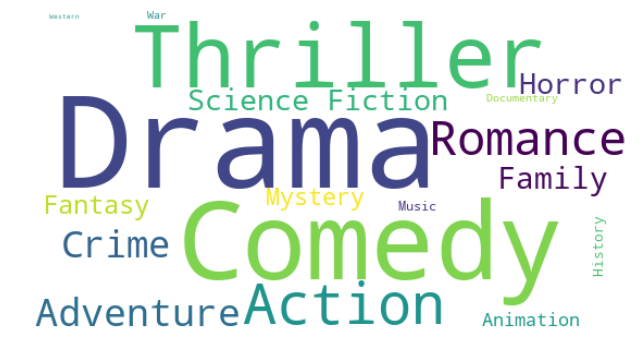

In [21]:
words = dict()
trunc_occurences = df1.groupby(["genres"]).size().sort_values(ascending=False).reset_index()
trunc_occurences.columns = ["genres", "frequency"]
for i in range(18):
    words[trunc_occurences["genres"][i]] = trunc_occurences["frequency"][i]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [26]:
genres = ["Drama","Comedy","Action","Adventure","Crime","Science", "Fiction","Family"]

In [27]:
grouped_data = df1[df1["genres"].isin(genres)].groupby(["genres","year"]).profit.mean().reset_index()

In [28]:
grouped_data.head(3)

,genres,year,profit
0,Action,1991,4.269032e+07
1,Action,1992,1.279588e+08
2,Action,1993,3.395408e+07


In [33]:
dict_group_data = {"xs":[grouped_data.loc[(grouped_data["genres"]==name),"year"].values \
                         for name in grouped_data['genres'].unique()],
                  "ys": [grouped_data.loc[(grouped_data["genres"]==name),"profit"].values\
                         for name in grouped_data['genres'].unique()],
                  "labels": grouped_data["genres"].unique(),
                  "color": bokeh.palettes.Category10[9]}

source = ColumnDataSource(dict_group_data)

hover = HoverTool(tooltips=[
    ("Genre", "@labels"),
])

p = figure(x_axis_label = 'year', 
           y_axis_label = 'profit', 
           width = 1000,
           tools=[hover, "save","pan","box_zoom","reset","wheel_zoom"]) 

p.multi_line(xs= "xs", ys= "ys", line_color= "color", source = source, legend = "labels",line_width=3)
p.legend.location = "top_left"

p.title.text = "Profit for each Genre across years"
p.title.align = "center"
p.title.text_font_size = "20px"

show(p)

### Finding Correlation between Profit & Popularity

In [22]:
data["profit"].corr(data["popularity"])

0.6206384045302814

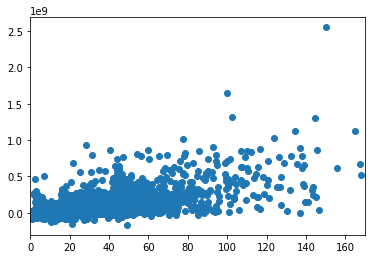

In [23]:
plt.scatter(data["popularity"],data["profit"])
plt.xlim([0,170])
plt.show()

### Decade Extracting & Checking Trends Decade-wise

In [24]:
def extract_decade(x):
    return str(floor(x/10)*10)+"s"

In [25]:
data["decade"] = data["year"].apply(extract_decade)

It looks like people have started giving lower rates in recent years and more people are giving rating compared to previous decades. Can you work on reordering the x axis labels chronologically?

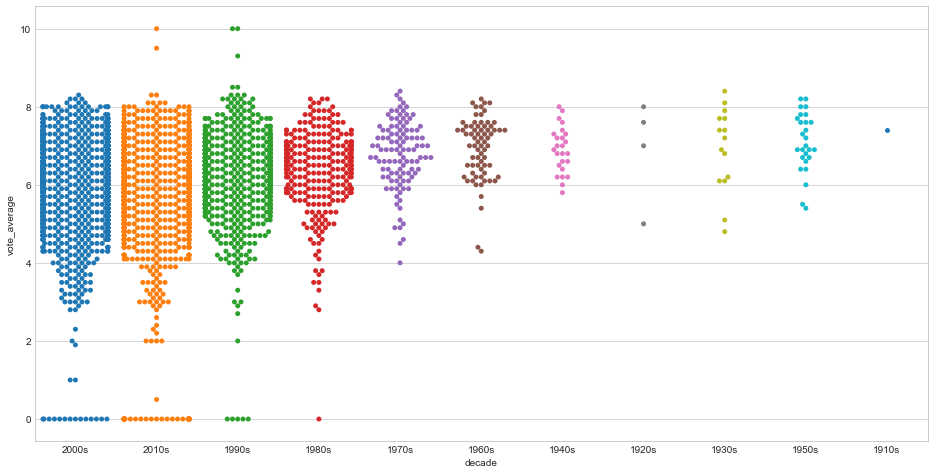

In [26]:
import seaborn as sns

sns.set_style("whitegrid")

fig=plt.figure(figsize=(16, 8))
sns.swarmplot(x="decade", y="vote_average", data=data , palette="tab10" )
plt.show()

In [39]:
data.groupby("decade").vote_average.mean()[2:].reset_index()

,decade,vote_average
0,1930s,6.920000
1,1940s,6.900000
2,1950s,7.092593
3,1960s,6.942254
4,1970s,6.774312
5,1980s,6.371583
6,1990s,6.237918
7,2000s,6.069521
8,2010s,5.862796


In [40]:
p = figure(x_axis_label = 'year', 
           y_axis_label = 'profit', 
           width = 1000,
           title = "Rating vs Budget with duration",
           tools=TOOLS) 


source = ColumnDataSource(data)
p.scatter(x= "budget", y= "vote_average",source=source, color='runtime')
p.legend.location = "top_left"
show(p)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


**Can you work on customizing the runtime values because currently it looks like most of the observations are between 100-200**

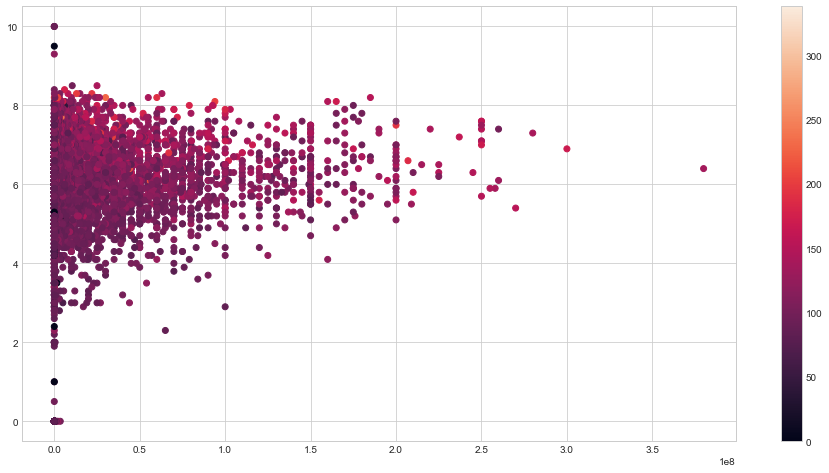

In [41]:
fig=plt.figure(figsize=(16, 8))
plt.scatter(x = data["budget"], y = data["vote_average"], c = data.runtime)
plt.colorbar()
plt.show()